In [31]:
import os
os.environ['QT_QPA_PLATFORM']='offscreen'
#os.environ['QT_QWS_FONTDIR']='/home/user/lib/fonts-qt/'
import pandas as pd
import sys
from ete3 import Tree, TreeStyle, NodeStyle, TextFace, faces
from ete3 import NCBITaxa

def mard(df, c1, c2):
    a = abs(df[c1]-df[c2])/(df[c1]+df[c2])
    return a.sum()/a.count()

In [2]:
ncbi = NCBITaxa()

In [4]:
def taxa_layout(node):
    nameFace = faces.TextFace(node.name, fsize=6)
    faces.add_face_to_node(nameFace, node, column=0)
    # We can also create faces on the fly
    rankFace = faces.TextFace(node.rank, fsize=10)
    faces.add_face_to_node(rankFace, node, column=0)
    
    countFace = faces.TextFace(node.count, fsize=14, fgcolor='red')
    faces.add_face_to_node(countFace, node, column=0)
        
    # Note that this faces is added in "aligned" mode
    descFace = faces.TextFace(node.sci_name, fsize=12)
    descFace.margin_top = 10
    descFace.margin_bottom = 10
    descFace.border.margin = 1
    faces.add_face_to_node(descFace, node, column=0, aligned=True)

In [5]:
vibrio='/mnt/scratch1/hirak/meta_genome/downloads/vibrio/'
vibrio_all = '/mnt/scratch1/hirak/meta_genome/downloads/vibrio_all/'
results_dir = '/mnt/scratch1/hirak/meta_genome/downloads/result/leaveOneOut/'
tf = vibrio+"taxonomy/nodes.dmp"
ref = vibrio+"seqid2taxid.map"
taxa = []
id2rank = {}
with open(tf) as f:
    for line in f:
        toks = line.rstrip("\t|\n").split("\t|\t")
        taxa += [[int(toks[0]), int(toks[1]), toks[2]]]
        id2rank[int(toks[0])] = toks[2]
taxa_df = pd.DataFrame.from_records(taxa)
taxa_df.columns = ["taxaId", "pid", "rank"]
with open(ref) as f:
    refId2TaxId = pd.read_csv(f, header=None, sep="\t", names=["refName", "refId"])

In [52]:
#rpt20 = pd.read_csv('/mnt/scratch1/hirak/meta_genome/downloads/result/leaveOneOut/report/strain_20filt.rpt', sep='\t'
#                   , header=None)
def draw_tree(kraken_out, is_filtered=False, filtering_threshold=0):
    krk = pd.read_csv(kraken_out, sep='\t', header=None)
    if is_filtered:
        krk.columns = ['cu', 'rid', 'tid', 'len', 'perc', 'kmers']
    else:
        krk.columns = ['cu', 'rid', 'tid', 'len', 'kmers']
    krk_merged = pd.merge(krk, taxa_df, how='left', left_on='tid', right_on='taxaId')
    print('# of unclassified reads: {}'.format(len(krk_merged[krk_merged['tid'] == 0])))
    a=krk_merged[krk_merged['tid'] != 0][['tid', 'cu']].groupby('tid').count().reset_index()
    a = a[a['cu'] >= filtering_threshold]
    tree = ncbi.get_topology(list(a.tid), intermediate_nodes=True)
    for n in tree.traverse():
        f = a[a['tid'] == n.taxid]
        if f.empty:
            n.add_feature(pr_name='count',pr_value=0)
        else:
            n.add_feature(pr_name='count',pr_value=int(f['cu']))
    ts = TreeStyle()
    #ts.show_leaf_name = False
    ts.mode = "c"
    ts.layout_fn = taxa_layout
    return tree.render('%%inline', tree_style=ts)

def draw_report_tree(kraken_out, filtering_threshold=0):
    krk = pd.read_csv(results_dir+kraken_out, sep='\t', header=None)
    krk.columns = ['perc', 'count_agg', 'count', 'rank', 'taxaId', 'sci_name']
    
    print('# of unclassified reads: {}'.format(krk[krk['rank'] == 'U']['count']))
    tree = ncbi.get_topology(list(krk[(krk['rank'] != 'U') & (krk['count'] >= filtering_threshold)].taxaId), intermediate_nodes=True)
    for n in tree.traverse():
        f = krk[krk['taxaId'] == n.taxid]
        if f.empty:
            n.add_feature(pr_name='count',pr_value=0)
        else:
            n.add_feature(pr_name='count',pr_value=int(f['count']))
    ts = TreeStyle()
    #ts.show_leaf_name = False
    ts.mode = "c"
    ts.layout_fn = taxa_layout
    return tree.render('%%inline', tree_style=ts)
def draw_cedar_tree(cedar_out, is_filtered=False, filtering_threshold=0):
    if isinstance(cedar_out, str):
        krk = pd.read_csv(cedar_out, sep='\t')
    else:
        krk = cedar_out
    
    krk.columns = ['taxaId', 'rank', 'count']
    
    print('# of unclassified reads: {}'.format(krk[krk['rank'] == 'U']['count']))
    tree = ncbi.get_topology(list(krk[(krk['rank'] != 'U') & (krk['count'] >= filtering_threshold)].taxaId), intermediate_nodes=False)
    for n in tree.traverse():
        f = krk[krk['taxaId'] == n.taxid]
        if f.empty:
            n.add_feature(pr_name='count',pr_value=0)
        else:
            n.add_feature(pr_name='count',pr_value=int(f['count']))
    ts = TreeStyle()
    #ts.show_leaf_name = False
    #ts.mode = "c"
    ts.layout_fn = taxa_layout
    return tree.render('%%inline', tree_style=ts)
def compare(res1, res2, n1='in', n2='ex', is_filtered=False, filtering_threshold=0):
    ced1 = pd.read_csv(res1, sep='\t')
    ced2 = pd.read_csv(res2, sep='\t')
    ced1.columns = [n1+'_taxaId', n1+'_rank', n1+'_count']
    ced2.columns = [n2+'_taxaId', n2+'_rank', n2+'_count']
    ced1 = ced1[ced1[n1+'_count'] > filtering_threshold]
    ced2 = ced2[ced2[n2+'_count'] > filtering_threshold]
    
    merged = pd.merge(ced1, ced2, left_on = n1+'_taxaId', right_on=n2+'_taxaId', how='outer')
    return merged.sort_values(['in_count'], ascending=False).fillna(0)[[n2+'_taxaId', n1+'_count', n2+'_count']]

# Coralliilyticus

Comparing Cases where we map agains a database of vibrios
 1. Including that one strain of Coralliilyticus
 2. Excluding that one strain from the database

# Chosen Chromosomes and count of simulated reads (Truth)
1. NZ_CP009264.1 Vibrio coralliilyticus strain OCN014 chromosome 1, complete sequence | count: 34558
2. NZ_CP009265.1 Vibrio coralliilyticus strain OCN014 chromosome 2, complete sequence | count: 18633
3. NZ_CP009266.1 Vibrio coralliilyticus strain OCN014 plasmid pOCN014, complete sequence>NZ_CP009264.1 Vibrio coralliilyticus strain OCN014 chromosome 1, complete sequence | count: 3815

In [74]:
cl = {'chr':['NZ_CP009264.1', 'NZ_CP009265.1', 'NZ_CP009266.1'], 'simulated read count':[34558, 18633, 3815]}
pd.DataFrame(columns=['chr', 'simulated read count'], data=cl)

,chr,simulated read count
0,NZ_CP009264.1,34558
1,NZ_CP009265.1,18633
2,NZ_CP009266.1,3815


## 1. At the level of strains
other than the 3 main chromosomes, we have scattered abundances associated to other strains
Excluding the 3 sources of reads, the order of abundances of other strains is still the same, but this time much more reads are mapped back to those species (which are around a few steps apart from the main source of read)

In [59]:
a = compare('/mnt/scratch1/hirak/meta_genome/pufferfish/coralla/cedar/in_flat_unfilt_ref_31.cedar',
       '/mnt/scratch1/hirak/meta_genome/pufferfish/coralla/cedar/ex_flat_unfilt_ref_31.cedar', filtering_threshold = 0)
a.head(20)

,ex_taxaId,in_count,ex_count
79,0,34427.50000,0.000000e+00
80,0,18610.20000,0.000000e+00
81,0,3806.66000,0.000000e+00
10,NZ_CP009617.1,35.34590,1.276980e+04
90,NZ_CP016556.1,20.44090,8.888260e+03
101,NZ_CP020453.1,13.96250,1.011630e+04
102,NZ_CP020454.1,8.70571,5.765500e+03
91,NZ_CP016557.1,7.48370,4.517850e+03
11,NZ_CP009618.1,6.59809,7.507710e+03
70,NZ_CP009354.1,5.26022,1.061450e+02


## 2. At the level of species
Cedar does a pretty good job

In [60]:
a = compare('/mnt/scratch1/hirak/meta_genome/pufferfish/coralla/cedar/in_unfilt_ref_31.cedar',
       '/mnt/scratch1/hirak/meta_genome/pufferfish/coralla/cedar/ex_unfilt_ref_31.cedar')
a.head(15)

,ex_taxaId,in_count,ex_count
10,190893,5.694480e+04,5.236740e+04
3,29498,5.149540e+00,1.192260e+02
11,691,3.000560e+00,8.215240e+00
5,669,2.436210e+00,2.608360e+01
13,668,2.002420e+00,5.003840e+00
14,670,1.564030e+00,2.424450e+01
2,52443,1.000130e+00,1.000140e+01
9,55601,1.000130e+00,2.670620e+01
0,696485,1.000080e+00,2.680010e+01
6,1435069,1.000030e+00,2.000030e+00


# when we have the source strain in the database

# of unclassified reads: Series([], Name: count, dtype: float64)


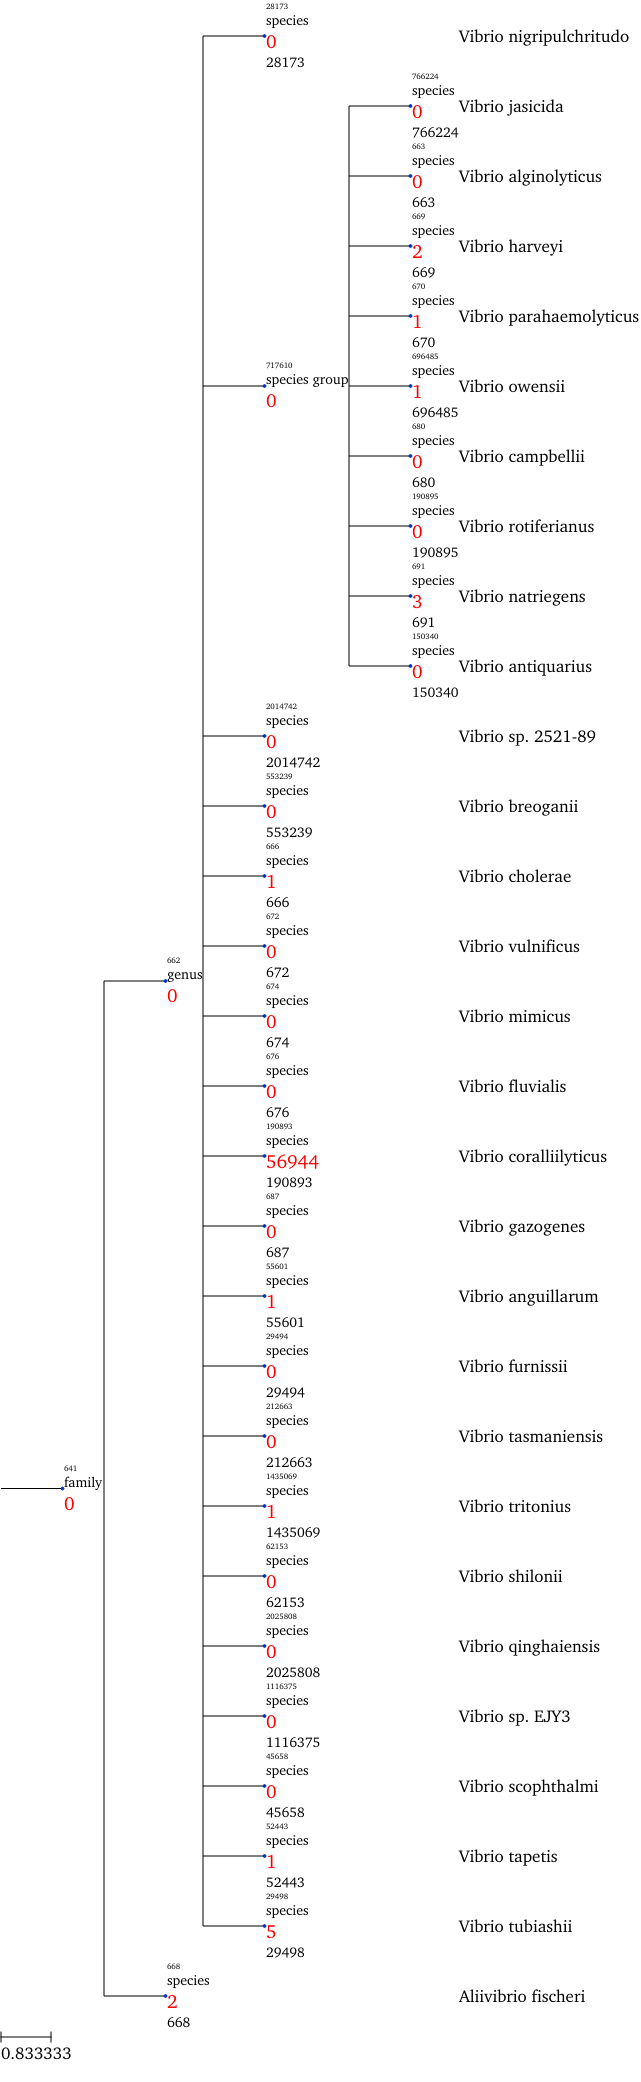

In [61]:
draw_cedar_tree('/mnt/scratch1/hirak/meta_genome/pufferfish/coralla/cedar/in_unfilt_ref_31.cedar')

# When we don't have the source strain in the database

# of unclassified reads: Series([], Name: count, dtype: float64)


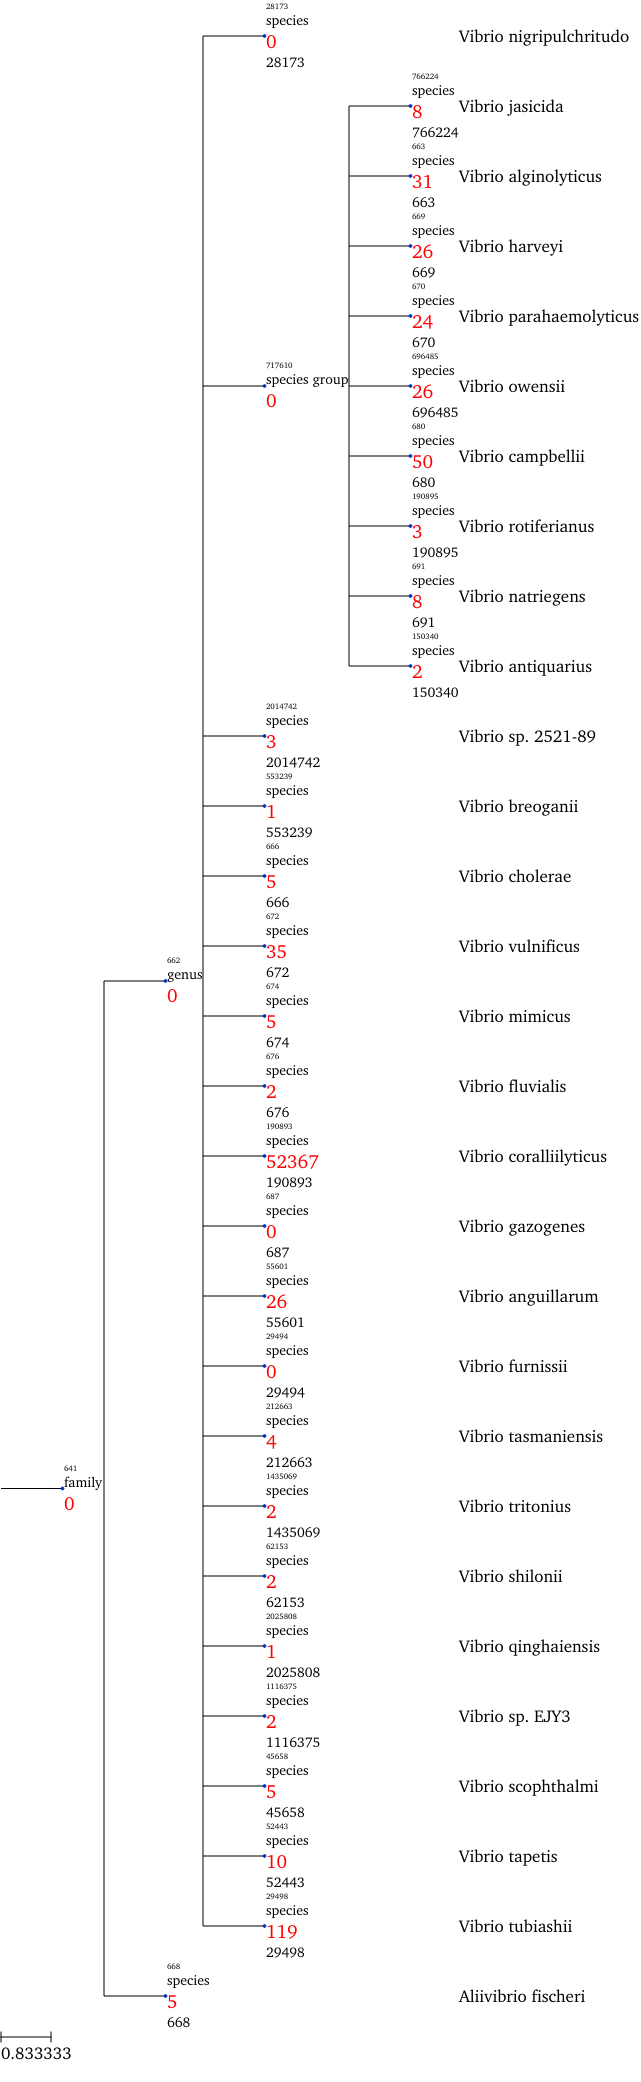

In [62]:
draw_cedar_tree('/mnt/scratch1/hirak/meta_genome/pufferfish/coralla/cedar/ex_unfilt_ref_31.cedar')

# Comparing Alignment output with Mapping output
We expect that using exact alignment, we will get better results that are very close to the true abundances at the lowest level of the tree 

In [69]:
a=compare('/mnt/scratch1/hirak/meta_genome/pufferfish/coralla/cedar/coralla_in_gen.sam',
            '/mnt/scratch1/hirak/meta_genome/pufferfish/coralla/cedar/in_flat_unfilt_ref_31.cedar')
a.columns = [['taxaId', 'alignment_count', 'mapping_count']]
a.head(15)

,taxaId,alignment_count,mapping_count
107,NZ_CP009264.1,34450.400000,3.442750e+04
108,NZ_CP009265.1,18626.500000,1.861020e+04
109,NZ_CP009266.1,3818.040000,3.806660e+03
14,NZ_CP009617.1,38.190800,3.534590e+01
123,NZ_CP016556.1,36.945000,2.044090e+01
15,NZ_CP009618.1,7.390710,6.598090e+00
67,0,4.089520,0.000000e+00
57,NZ_CP017913.1,3.624260,1.573490e-170
97,NZ_CP009354.1,3.507630,5.260220e+00
103,NZ_CP014035.1,3.090450,1.975670e-16
